# Instructions
The goal of this Python notebook is to lay out the data preprocessing stage of training the model.

The steps to be done in this notebook are as done in the paper by Almalki

### Steps
1. Join the transactions and identity tables
2. Remove the TransactionId as it is unnecessary
3. Handle missing data by using the most frequent categories or using the median of each numerical feature
4. Use label encoding for converting categorical features to numeric representations
5. Use SMOTE to handle class imbalance
6. Train an XGBoost Classifier on the full training data and then get the top 30 features with the highest mean absolute SHAP
7. Identify and optimize your system architecture's hyperparameters

In [24]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [12]:
# Join the transactions and identity tables
train_identity_df = pd.read_csv('datasets/train_identity.csv')
print(f"Train Identity Shape: {train_identity_df.shape}")

train_transactions_df = pd.read_csv('datasets/train_transaction.csv')
print(f"Train Transactions Shape: {train_transactions_df.shape}")

train_df = pd.merge(train_transactions_df, train_identity_df, on='TransactionID', how='left')
print(f"Train Shape: {train_df.shape}")

Train Identity Shape: (144233, 41)
Train Transactions Shape: (590540, 394)
Train Shape: (590540, 434)


In [13]:
# Remove the TransactionID feature
train_df.drop(columns=['TransactionID'], inplace=True)
print(f"Train Shape: {train_df.shape}")

Train Shape: (590540, 433)


In [18]:
# Handle missing data
train_df_without_missing_data = train_df.copy()
for column in train_df.columns:
    if train_df[column].isnull().sum() > 0:
        if train_df[column].dtype == 'object':
            train_df_without_missing_data.fillna({column: train_df[column].mode()[0]}, inplace=True)
        else:
            train_df_without_missing_data.fillna({column: train_df[column].median()}, inplace=True)

print(f"Train Shape: {train_df_without_missing_data.shape}")

# Check the result of the previous step
train_df_without_missing_data.isnull().sum().sum()
train_df_without_missing_data.head(10)

Train Shape: (590540, 433)


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,W,13926,361.0,150.0,discover,142.0,credit,...,chrome 63.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,chrome 63.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,chrome 63.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,chrome 63.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,...,chrome 63.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
6,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,...,chrome 63.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
7,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,...,chrome 63.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
8,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,...,chrome 63.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows


In [17]:
# Label Encoding

train_df_with_label_encoding = train_df_without_missing_data.copy()

# Step 1: Identify categorical columns
categorical_columns = train_df_with_label_encoding.select_dtypes(include=['object']).columns

# Store label encoders
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    train_df_with_label_encoding[column] = le.fit_transform(train_df_with_label_encoding[column])
    label_encoders[column] = le

train_df_with_label_encoding.head(10)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,4,13926,361.0,150.0,1,142.0,1,...,47,24.0,132,3,1,0,1,0,0,1598
1,0,86401,29.0,4,2755,404.0,150.0,2,102.0,1,...,47,24.0,132,3,1,0,1,0,0,1598
2,0,86469,59.0,4,4663,490.0,150.0,3,166.0,2,...,47,24.0,132,3,1,0,1,0,0,1598
3,0,86499,50.0,4,18132,567.0,150.0,2,117.0,2,...,47,24.0,132,3,1,0,1,0,0,1598
4,0,86506,50.0,1,4497,514.0,150.0,2,102.0,1,...,123,32.0,164,3,1,0,1,1,1,954
5,0,86510,49.0,4,5937,555.0,150.0,3,226.0,2,...,47,24.0,132,3,1,0,1,0,0,1598
6,0,86522,159.0,4,12308,360.0,150.0,3,166.0,2,...,47,24.0,132,3,1,0,1,0,0,1598
7,0,86529,422.5,4,12695,490.0,150.0,3,226.0,2,...,47,24.0,132,3,1,0,1,0,0,1598
8,0,86535,15.0,1,2803,100.0,150.0,3,226.0,2,...,98,32.0,48,2,1,0,0,1,1,1727
9,0,86536,117.0,4,17399,111.0,150.0,2,224.0,2,...,47,24.0,132,3,1,0,1,0,0,1598


In [ ]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

# Separate features (x) and (y)
x = train_df_with_label_encoding.drop(columns=['isFraud'], axis=1)
y = train_df_with_label_encoding['isFraud']

x_resampled, y_resampled = smote.fit_resample(x, y)

balanced_df = pd.concat([x_resampled, y_resampled], axis=1)
balanced_df.shape

(1139754, 433)

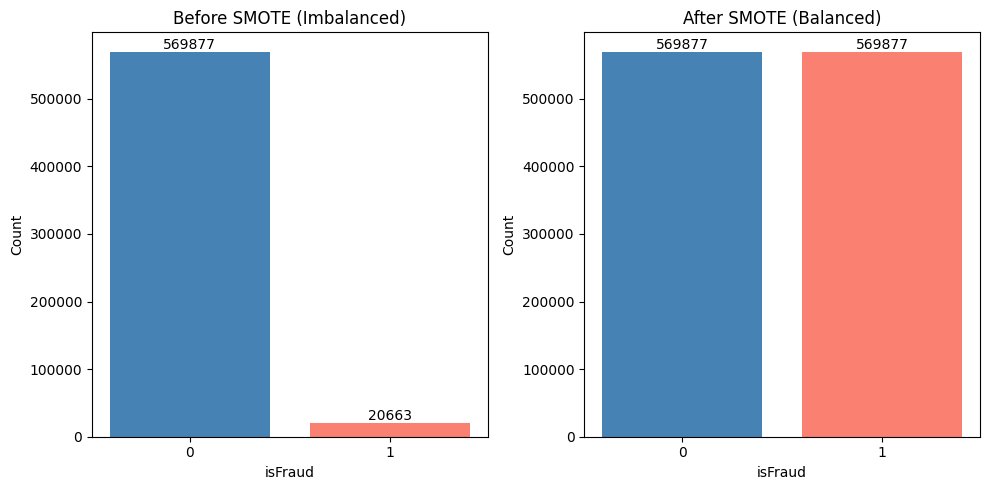

In [25]:
# View the results of the balanced dataframe dataset

# Count of 'isFraud' before and after SMOTE
before_counts = train_df_with_label_encoding['isFraud'].value_counts()
after_counts = balanced_df['isFraud'].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Before SMOTE ---
axes[0].bar(before_counts.index.astype(str), before_counts.values, color=['steelblue', 'salmon'])
axes[0].set_title('Before SMOTE (Imbalanced)')
axes[0].set_xlabel('isFraud')
axes[0].set_ylabel('Count')
axes[0].bar_label(axes[0].containers[0])  # show counts on bars

# --- After SMOTE ---
axes[1].bar(after_counts.index.astype(str), after_counts.values, color=['steelblue', 'salmon'])
axes[1].set_title('After SMOTE (Balanced)')
axes[1].set_xlabel('isFraud')
axes[1].set_ylabel('Count')
axes[1].bar_label(axes[1].containers[0])  # show counts on bars

# Adjust layout and display
plt.tight_layout()
plt.show()

c:\Users\Elevate\Documents\Thesis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    113976
           1       1.00      0.98      0.99    113975

    accuracy                           0.99    227951
   macro avg       0.99      0.99      0.99    227951
weighted avg       0.99      0.99      0.99    227951


Confusion Matrix:
 [[113647    329]
 [  2773 111202]]


100%|===================| 227801/227951 [32:32<00:01]        

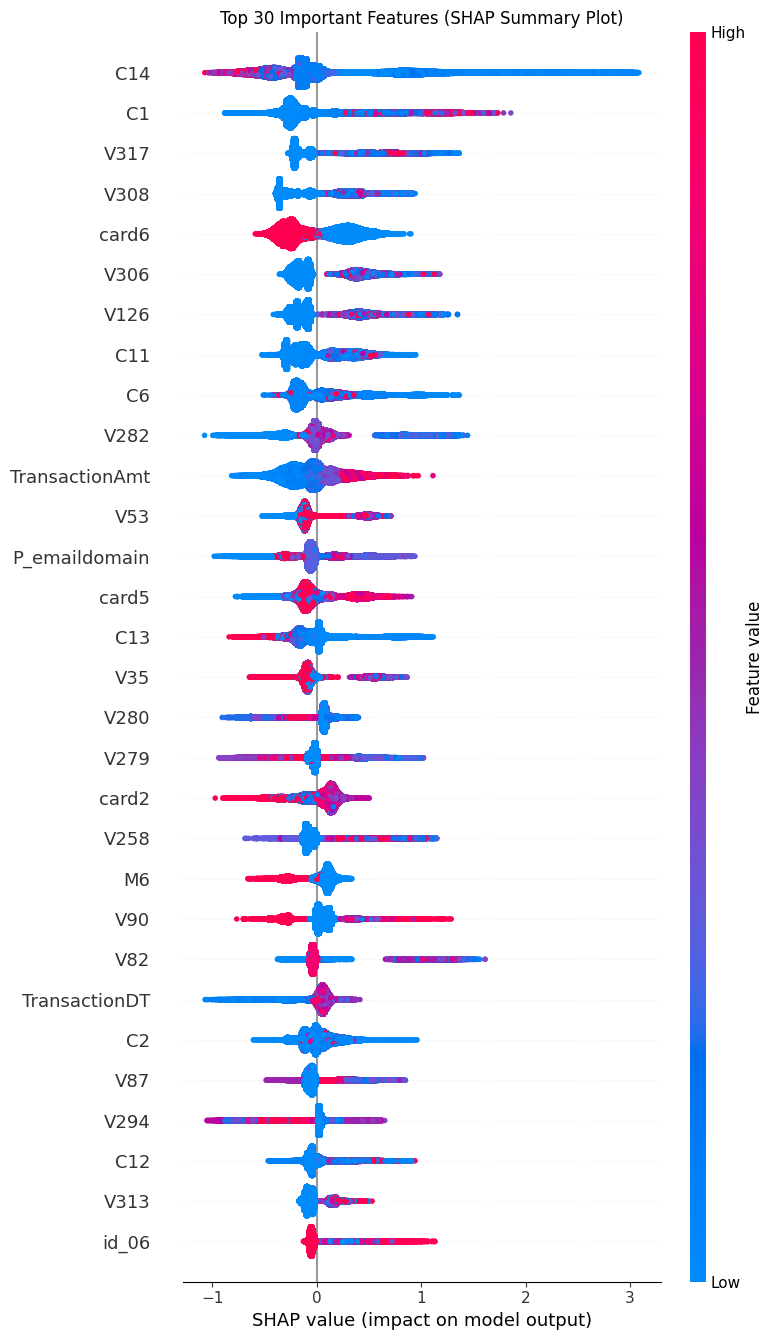

In [26]:
# Train XGBoost Classifier and use SHAP to find top 30 features

# ======================
# 1️⃣ Import libraries
# ======================
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt

# ======================
# 2️⃣ Prepare data
# ======================
X = balanced_df.drop('isFraud', axis=1)
y = balanced_df['isFraud']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ======================
# 3️⃣ Train XGBoost Classifier
# ======================
model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

model.fit(X_train, y_train)

# ======================
# 4️⃣ Evaluate model
# ======================
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ======================
# 5️⃣ Compute SHAP values
# ======================
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# ======================
# 6️⃣ Visualize top 30 features
# ======================
plt.title("Top 30 Important Features (SHAP Summary Plot)")
shap.summary_plot(shap_values, X_test, max_display=30)
